In [1]:
import warnings

from matplotlib import pyplot as plt

warnings.filterwarnings("ignore")
import torch

import pandas as pd
import numpy as np
import scanpy as sc
import os
import yaml
from pathlib import Path

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['R_HOME'] = 'D:/software/R/R-4.3.2'
os.environ['R_USER'] = 'D:/software/anaconda/anaconda3/envs/pt20cu118/Lib/site-packages/rpy2'
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.decomposition import PCA



# %%
import SpaCross as TOOLS

def load_data(config):
    adata = sc.read_visium('D:/project/datasets/Mouse_Brain_Anterior_Section1',
                           count_file='filtered_feature_bc_matrix.h5')
    adata.var_names_make_unique()

    ##### Load layer_guess label, if have
    turth_path = 'D:/project/datasets/Mouse_Brain_Anterior_Section1/metadata.tsv'
    truth_labels = pd.read_csv(turth_path, sep='\t', header=0)
    truth_labels.index = adata.obs_names
    adata.obs['layer_guess'] = truth_labels['ground_truth']

    edge_index = TOOLS.graph_construction(adata, config['data']['k_cutoff'])

    adata.layers['count'] = adata.X
    sc.pp.filter_genes(adata, min_cells=50)
    sc.pp.filter_genes(adata, min_counts=10)
    sc.pp.normalize_total(adata, target_sum=1e6)
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count', n_top_genes=config['data']['top_genes'])
    adata = adata[:, adata.var['highly_variable'] == True]
    sc.pp.scale(adata)

    adata_X = PCA(n_components=200, random_state=42).fit_transform(adata.X)
    adata.obsm['X_pca'] = adata_X
    return adata, edge_index

In [2]:
with open('../Config/MBA.yaml', 'r', encoding='utf-8') as f:
    config = yaml.load(f.read(), Loader=yaml.FullLoader)

In [3]:
adata, edge_index = load_data(config)

In [4]:
num_clusters = 52
# %%
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
net = TOOLS.SC_pipeline(adata, edge_index=edge_index, num_clusters=num_clusters, device=device, config=config,
                 imputation=False)
# %%
net.trian()
# %%
enc_rep, recon = net.process()
adata.obsm['latent'] = enc_rep
adata.obsm['recon'] = recon

Epoch 299 total loss=1.977 recon loss=0.624 mean loss=0.375 tri loss=1.365: 100%|██████████| 300/300 [00:09<00:00, 30.76it/s]


In [5]:
# %%
clusType = "mclust"
adata.obs[clusType] = TOOLS.clustering(z=enc_rep, n_clust=num_clusters, num_seed=1, method=clusType)
adata.obs[clusType] = TOOLS.refine_label(adata, 50, key=clusType)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [6]:
ARI, ACC, DIS = TOOLS.get_metrics(adata, 'layer_guess', clusType)
print(f"ARI: {round(ARI, 4)} ACC: {round(ACC, 4)} DIS: {round(DIS, 4)}")

ARI: 0.4998 ACC: 0.7043 DIS: 0.0848


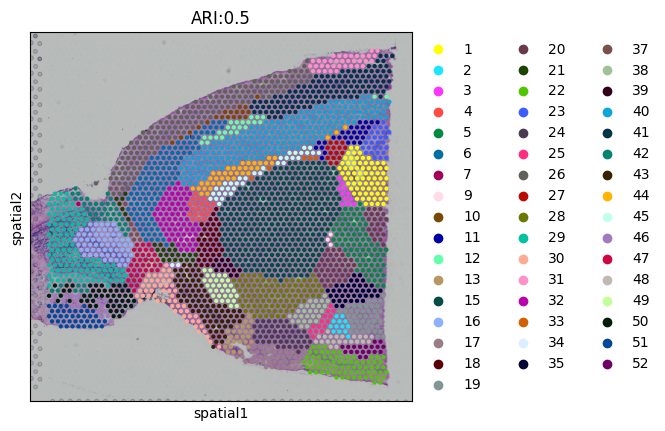

In [7]:
sc.pl.spatial(adata, color=[clusType],
              title='ARI:' + str(round(ARI, 3)), show=True, spot_size=100, save=False)